In [1]:
import pandas as pd
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

In [2]:
data = pd.read_csv('87278757_all_X.csv')
Y = pd.read_csv('87278757_all_Y.csv')

In [3]:
X = data.drop(columns=['match_id','version','start_time'])
X = X.fillna(0)
x_train = X.iloc[:690,:]
x_test  = X.iloc[690:,:]
y_train = Y.iloc[:690,:]
y_test = Y.iloc[690:,:]

In [4]:
clf = RandomForestClassifier(n_estimators=10)

In [55]:
def plotHeroUsage(Y,N):
    heroes = Y['hero_picked'].unique()
    counts = []
    for hero in heroes:
        counts.append(len(Y[Y['hero_picked'] == hero]))
    counts = np.array(counts)
    heroes = heroes[counts.argsort()[-N:]]
    counts = counts[counts.argsort()[-N:]]
    y_pos = np.arange(len(heroes))
    plt.bar(y_pos,counts, align='center', alpha=0.5)
    plt.xticks(y_pos,heroes)
    plt.ylabel('counts')
    plt.title('Hero usage')
    plt.show()

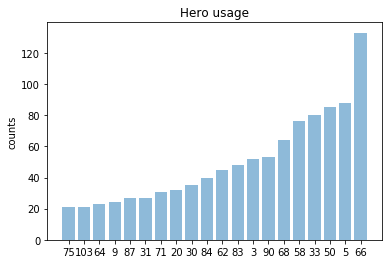

In [56]:
plotHeroUsage(Y,20)

In [5]:
clf = clf.fit(x_train,y_train)

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


In [7]:
np.sum(np.array(y_test).flatten() == clf.predict(x_test)) 

46